
# Delta–Vega Hedging (SPX) — Using OptionMetrics **OMunderlying.csv** for Spot

This notebook replaces the Yahoo Finance spot with **OMunderlying.csv** (OptionMetrics) and keeps the rest of the pipeline:
- Load options parquet (`options_dataset.parquet`), fix OPRA strike scaling.
- Load **OMunderlying.csv** and use **`close`** as SPX spot.
- Build non-overlapping **21-trading-day** windows (≈1 month).
- Construct single-straddle target with \( K = m_0 S_0 \), \(m_0 \in \{0.75,0.8,0.9,1.1,1.2,1.25\}\).
- Daily **delta–vega** rebalancing with **ATM-at-inception** hedge option + underlying.
- Half-spread costs on the option hedge leg.
- Backtest from **2021-01-01** to end of dataset; plots + CSV output.


In [2]:

# === 1) Imports & Params ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional

TRADING_DAYS_PER_MONTH = 21
VEGA_FLOOR = 5.0  # vega floor for stability in hedge ratio

# Paths (adjust if needed)
OPTIONS_PARQUET = "../../data/options_dataset.parquet"
OM_UNDERLYING_CSV = "../../data/OMunderlying.csv"

pd.set_option('display.width', 160)
pd.set_option('display.max_columns', 50)


In [4]:
df_1m = pd.read_csv('../FilteredDataset.csv', index_col=0)
df_1m['date'] = pd.to_datetime(df_1m['date'])
df_1m['exdate'] = pd.to_datetime(df_1m['exdate'])
print(f"\nFinal filtered dataset: {len(df_1m)} rows")
df_1m.head(10)



Final filtered dataset: 28073947 rows


,date,exdate,cp_flag,strike_price,spot,moneyness,dte,mid,best_bid,best_offer,volume,open_interest,delta,vega,impl_volatility,spread,rel_spread
0,2000-01-03,2000-01-22,P,1275.0,1455.22,0.876156,19,2.0000,1.750,2.250,585,23785,-0.041295,28.57753,0.358787,0.500,0.250000
1,2000-01-03,2000-01-22,P,1300.0,1455.22,0.893336,19,2.6250,2.250,3.000,3572,26621,-0.055490,36.20153,0.334738,0.750,0.285714
2,2000-01-03,2000-01-22,P,1325.0,1455.22,0.910515,19,3.8125,3.500,4.125,1406,30757,-0.079749,47.92918,0.317378,0.625,0.163934
3,2000-01-03,2000-01-22,C,1325.0,1455.22,0.910515,19,134.5000,133.500,135.500,315,29529,0.983012,13.61578,0.207545,2.000,0.014870
4,2000-01-03,2000-01-22,C,1350.0,1455.22,0.927695,19,111.1250,110.125,112.125,112,20500,0.939732,38.63064,0.229941,2.000,0.017998
5,2000-01-03,2000-01-22,P,1350.0,1455.22,0.927695,19,5.1875,4.875,5.500,819,24413,-0.109956,60.74824,0.294041,0.625,0.120482
6,2000-01-03,2000-01-22,C,1375.0,1455.22,0.944874,19,88.5000,87.500,89.500,6,7885,0.884385,62.96457,0.229135,2.000,0.022599
7,2000-01-03,2000-01-22,P,1375.0,1455.22,0.944874,19,6.9375,6.750,7.125,2633,18270,-0.150684,75.57642,0.267472,0.375,0.054054
8,2000-01-03,2000-01-22,C,1380.0,1455.22,0.948310,19,84.0000,83.000,85.000,4,13,0.872528,67.43791,0.226489,2.000,0.023810
9,2000-01-03,2000-01-22,P,1380.0,1455.22,0.948310,19,8.1250,7.625,8.625,69,1458,-0.168821,81.41239,0.271506,1.000,0.123077


In [5]:

# === 5) Utilities (small, testable) ===
def choose_strike_for_m0(spot0: float, m0: float, available_strikes: np.ndarray) -> float:
    target = float(m0) * float(spot0)
    idx = np.abs(available_strikes - target).argmin()
    K = float(available_strikes[idx])
    return K

def nearest_atm_strike(spot0: float, available_strikes: np.ndarray) -> float:
    idx = np.abs(available_strikes - float(spot0)).argmin()
    K = float(available_strikes[idx])
    return K

def pick_one(day_df: pd.DataFrame, strike: float, cp_flag: str) -> Optional[pd.Series]:
    sub = day_df[(day_df['strike_price'] == strike) & (day_df['cp_flag'] == cp_flag)].copy()
    if sub.empty:
        print(f"[pick_one] MISSING leg for cp={cp_flag}, K={strike}")
        return None
    sub = sub.replace([np.inf, -np.inf], np.nan).dropna(subset=['mid','delta','vega','best_bid','best_offer'])
    sub = sub[sub['best_offer'] >= sub['best_bid']].copy()
    if sub.empty:
        print(f"[pick_one] All candidates invalid for cp={cp_flag}, K={strike}")
        return None

    sub['spread'] = (sub['best_offer'] - sub['best_bid']).clip(lower=0)
    sub['rel_spread'] = (sub['spread'] / sub['mid']).replace([np.inf,-np.inf], np.nan)
    sub['dte_dist'] = (sub['dte'] - 21).abs()
    sub = sub.dropna(subset=['rel_spread'])
    sub = sub[(sub['rel_spread'] <= 0.35) & (sub['mid'] > 0.05)]
    if sub.empty:
        print(f"[pick_one] No clean candidate after filters for cp={cp_flag}, K={strike}")
        return None

    sub = sub.sort_values(by=['dte_dist','open_interest','volume','rel_spread'],
                          ascending=[True, False, False, True])
    chosen = sub.iloc[0]
    return chosen

def fetch_next_row(next_df, strike, cp_flag):
    sub = next_df[(next_df['strike_price'] == strike) & (next_df['cp_flag'] == cp_flag)].copy()
    if sub.empty:
        print(f"[next fetch] MISSING next-day row for cp={cp_flag}, K={strike}")
        return None
    sub = sub.replace([np.inf, -np.inf], np.nan).dropna(subset=['mid','delta','vega','best_bid','best_offer'])
    sub = sub[sub['best_offer'] >= sub['best_bid']].copy()
    if sub.empty:
        print(f"[next fetch] All next-day candidates invalid for cp={cp_flag}, K={strike}")
        return None

    sub['spread'] = (sub['best_offer'] - sub['best_bid']).clip(lower=0)
    sub['rel_spread'] = (sub['spread'] / sub['mid']).replace([np.inf,-np.inf], np.nan)
    sub['dte_dist'] = (sub['dte'] - 21).abs()
    sub = sub.dropna(subset=['rel_spread'])
    sub = sub[(sub['rel_spread'] <= 0.35) & (sub['mid'] > 0.05)]
    if sub.empty:
        print(f"[next fetch] No clean next-day candidate for cp={cp_flag}, K={strike}")
        return None

    sub = sub.sort_values(by=['dte_dist','open_interest','volume','rel_spread'],
                          ascending=[True, False, False, True])
    chosen = sub.iloc[0]
    return chosen

def half_spread(row: pd.Series) -> float:
    return float(max(0.0, (row['best_offer'] - row['best_bid']) / 2.0))

def pnl_from_price_change(qty: float, price_t: float, price_t1: float) -> float:
    return float(qty) * (float(price_t1) - float(price_t))

def self_financing_rebalance_cost(prev_qty: float, new_qty: float, half_spread_val: float) -> float:
    return abs(float(new_qty - prev_qty)) * float(half_spread_val)


In [6]:

# === 6A) Window builder ===
def get_window_dates(df_all: pd.DataFrame, start_idx: int) -> list[pd.Timestamp] | None:
    dates = np.sort(df_all['date'].unique())
    if start_idx + TRADING_DAYS_PER_MONTH >= len(dates):
        print(f"[get_window_dates] Not enough dates from start_idx={start_idx}.")
        return None
    days = list(dates[start_idx : start_idx + TRADING_DAYS_PER_MONTH + 1])
    return days


In [7]:
def one_day_step(
    df_all: pd.DataFrame,
    d: pd.Timestamp,
    d_next: pd.Timestamp,
    K_straddle: float,
    K_hedge: float,
    phi_opt_prev: float,
    phi_under_prev: float,
    allow_recalc: bool,
) -> dict | None:
    """
    do one step t -> t+1.
    if allow_recalc == True: recompute hedge ratios phi_opt, phi_under from Greeks today.
    if allow_recalc == False: reuse previous phi_opt_prev / phi_under_prev (no rebalance, no cost).
    """

    day = df_all[df_all['date'] == d].copy()
    day_next = df_all[df_all['date'] == d_next].copy()
    if day.empty or day_next.empty:
        print(f"[one_day_step] Missing day data at {d} or {d_next}")
        return None

    # pick straddle legs
    row_C = pick_one(day, K_straddle, 'C')
    row_P = pick_one(day, K_straddle, 'P')
    # pick hedge leg (ATM-at-inception strike, we keep using same strike for hedge instrument)
    row_H = pick_one(day, K_hedge, 'C')
    if row_H is None:
        row_H = pick_one(day, K_hedge, 'P')
    if (row_C is None) or (row_P is None) or (row_H is None):
        print("[one_day_step] Missing leg(s) at current day.")
        return None

    psi_C, psi_P = 1.0, 1.0

    # target portfolio (straddle) greeks and MTM today
    V_t   = psi_C*row_C['mid'] + psi_P*row_P['mid']
    dV_t  = psi_C*row_C['delta'] + psi_P*row_P['delta']
    kV_t  = psi_C*row_C['vega']  + psi_P*row_P['vega']

    dH_t  = row_H['delta']
    kH_t  = row_H['vega']

    vals = [V_t, dV_t, kV_t, dH_t, kH_t, row_H['mid']]
    if not all(np.isfinite(v) for v in vals):
        print(f"[one_day_step] Non-finite greeks/prices at {pd.Timestamp(d).date()} — abort window.")
        return None

    # vega floor for stability
    kH_eff = np.sign(kH_t) * max(abs(kH_t) if np.isfinite(kH_t) else 0.0, VEGA_FLOOR)
    if not np.isfinite(kV_t):
        print(f"[one_day_step] Portfolio vega NaN at {pd.Timestamp(d).date()} — abort window.")
        return None

    if allow_recalc:
        # fresh hedge ratios
        phi_opt   = (kV_t / kH_eff) if not np.isclose(kH_eff, 0.0) else 0.0
        phi_under = dV_t - phi_opt * dH_t
    else:
        # hold previous hedge, don't rebalance
        phi_opt   = phi_opt_prev
        phi_under = phi_under_prev

    # get next-day marks for pnl
    row_C_next = fetch_next_row(day_next, row_C['strike_price'], 'C')
    row_P_next = fetch_next_row(day_next, row_P['strike_price'], 'P')
    row_H_next = fetch_next_row(day_next, row_H['strike_price'], row_H['cp_flag'])
    if (row_C_next is None) or (row_P_next is None) or (row_H_next is None):
        print("[one_day_step] Missing next-day leg(s).")
        return None

    s_t  = float(row_C['spot'])
    s_t1 = float(row_C_next['spot'])

    # mark-to-market changes
    pnl_opt   = pnl_from_price_change(phi_opt,   row_H['mid'], row_H_next['mid'])
    pnl_under = pnl_from_price_change(phi_under, s_t,          s_t1)

    # trading cost:
    # - if we actually rebalanced today, pay cost on phi_opt change
    # - else no cost (you didn't trade)
    if allow_recalc:
        hs_H      = half_spread(row_H)
        cost_opt  = self_financing_rebalance_cost(phi_opt_prev, phi_opt, hs_H)
    else:
        cost_opt  = 0.0
    cost_under = 0.0  # still zero for underlying leg

    # unhedged daily pnl of the straddle
    pnl_unhedged = (psi_C*(row_C_next['mid'] - row_C['mid']) +
                    psi_P*(row_P_next['mid'] - row_P['mid']))

    return dict(
        date=pd.Timestamp(d),
        spot=s_t,
        K_straddle=K_straddle,
        K_hedge=K_hedge,
        V_t=float(V_t),
        dV_t=float(dV_t),
        kV_t=float(kV_t),
        dH_t=float(dH_t),
        kH_t=float(kH_t),
        kH_eff=float(kH_eff),
        phi_opt=float(phi_opt),
        phi_under=float(phi_under),
        cost_opt=float(cost_opt),
        cost_under=float(cost_under),
        pnl_opt=float(pnl_opt),
        pnl_under=float(pnl_under),
        pnl_unhedged=float(pnl_unhedged),
        rebalanced_today=bool(allow_recalc),
    )


In [14]:
def run_single_window(
    df_all: pd.DataFrame,
    start_idx: int,
    m0: float,
    rebalance_every: int = 1,  # 1=daily, 5=weekly
) -> dict | None:
    """
    Simulate one 21-trading-day window from start_idx.
    rebalance_every controls hedge frequency.
    """

    # get the day sequence
    days = get_window_dates(df_all, start_idx)
    if days is None:
        return None
    d0 = pd.Timestamp(days[0])
    day0 = df_all[df_all['date'] == d0].copy()
    if day0.empty:
        print(f"[run_single_window] No rows on start day {d0}.")
        return None

    # initial strikes
    spot0 = float(day0['spot'].iloc[0])
    strikes0 = np.sort(day0['strike_price'].unique())
    K_straddle = choose_strike_for_m0(spot0, m0, strikes0)
    K_hedge    = nearest_atm_strike(spot0, strikes0)

    # hedge positions from previous day
    phi_opt_prev   = 0.0
    phi_under_prev = 0.0

    records = []
    V0 = None
    Pi_t = None  # hedge book value Π_t

    for t in range(len(days)-1):
        d      = pd.Timestamp(days[t])
        d_next = pd.Timestamp(days[t+1])

        # only recalc hedge every rebalance_every steps
        allow_recalc = (t % rebalance_every == 0)

        step = one_day_step(
            df_all=df_all,
            d=d,
            d_next=d_next,
            K_straddle=K_straddle,
            K_hedge=K_hedge,
            phi_opt_prev=phi_opt_prev,
            phi_under_prev=phi_under_prev,
            allow_recalc=allow_recalc,
        )
        if step is None:
            print("[run_single_window] Step failed; abort window.")
            return None

        # initialize book on first day
        if V0 is None:
            V0 = step['V_t']
            Pi_t = V0
            print(f"[init] V0=Π0={V0:.6f}")

        # self-financing update of hedge book
        Pi_t1 = (
            Pi_t
            + step['pnl_opt']
            + step['pnl_under']
            - step['cost_opt']
            - step['cost_under']
        )

        # store tracking error vs target that day (pre-next-day move)
        step['Pi_t']  = float(Pi_t)
        step['Pi_t1'] = float(Pi_t1)
        step['Z_t']   = float(step['V_t'] - Pi_t)

        records.append(step)

        # carry forward hedge positions (whatever we actually hold after today)
        phi_opt_prev   = step['phi_opt']
        phi_under_prev = step['phi_under']
        Pi_t = Pi_t1

    # final valuation at expiry-ish (last day in this window)
    last_day  = pd.Timestamp(days[-2])
    final_day = pd.Timestamp(days[-1])
    day_last  = df_all[df_all['date'] == last_day]
    day_final = df_all[df_all['date'] == final_day]

    row_C_last = pick_one(day_last,  K_straddle, 'C')
    row_C_fin  = fetch_next_row(day_final, K_straddle, 'C')
    row_P_last = pick_one(day_last,  K_straddle, 'P')
    row_P_fin  = fetch_next_row(day_final, K_straddle, 'P')
    if (row_C_last is None) or (row_P_last is None) or (row_C_fin is None) or (row_P_fin is None):
        print("[run_single_window] Final valuation missing legs.")
        return None

    V_T = float(row_C_fin['mid'] + row_P_fin['mid'])
    Pi_T = float(records[-1]['Pi_t1'])

    tracking_error_T = V_T - Pi_T
    pnl_unhedged_total = V_T - float(records[0]['V_t'])
    pnl_hedged_total   = Pi_T - float(records[0]['V_t'])

    timeline = pd.DataFrame(records).sort_values('date').reset_index(drop=True)

    summary = dict(
        start=days[0],
        end=days[-1],
        m0=float(m0),
        rebalance_every=int(rebalance_every),
        K_straddle=float(K_straddle),
        K_hedge=float(K_hedge),
        V0=float(records[0]['V_t']),
        V_T=float(V_T),
        Pi_T=float(Pi_T),
        tracking_error=float(tracking_error_T),
        pnl_unhedged=float(pnl_unhedged_total),
        pnl_hedged=float(pnl_hedged_total),
    )
    return dict(timeline=timeline, summary=summary)


In [9]:

# === 7) Multi-window experiment ===
def run_experiment_verbose(df_all: pd.DataFrame, m0_list: list[float], max_windows: int = 52, stop_on_fail: bool = False) -> pd.DataFrame:
    dates = np.sort(df_all['date'].unique())
    start_indices = list(range(0, len(dates) - TRADING_DAYS_PER_MONTH - 1, TRADING_DAYS_PER_MONTH))
    start_indices = start_indices[:max_windows]
    results = []
    for m0 in m0_list:
        print(f"\n===== m0={m0} =====")
        for i, si in enumerate(start_indices, 1):
            print(f"\n--- Window {i}/{len(start_indices)} (start_idx={si}) ---")
            out = run_single_window(df_all, si, m0)
            if out is None:
                print(f"[run_experiment_verbose] Window failed for m0={m0}, start_idx={si}.")
                if stop_on_fail:
                    return pd.DataFrame(results)
                else:
                    continue
            results.append(out['summary'])
    return pd.DataFrame(results)


In [10]:
def run_experiment_with_freqs(
    df_all: pd.DataFrame,
    m0_list: list[float],
    rebalance_list: list[int],
    max_windows: int = 52,
    stop_on_fail: bool = False,
) -> pd.DataFrame:
    """
    For each m0 and each rebalance frequency, run all non-overlapping windows.
    Returns one big results_df with columns including rebalance_every.
    """
    dates = np.sort(df_all['date'].unique())
    start_indices = list(range(
        0,
        len(dates) - TRADING_DAYS_PER_MONTH - 1,
        TRADING_DAYS_PER_MONTH
    ))
    start_indices = start_indices[:max_windows]

    results = []

    for m0 in m0_list:
        for freq in rebalance_list:
            print(f"\n===== m0={m0}, freq={freq} =====")
            for i, si in enumerate(start_indices, 1):
                print(f"\n--- Window {i}/{len(start_indices)} (start_idx={si}) ---")
                out = run_single_window(
                    df_all=df_all,
                    start_idx=si,
                    m0=m0,
                    rebalance_every=freq,
                )
                if out is None:
                    print(f"[run_experiment_with_freqs] FAILED m0={m0}, freq={freq}, start_idx={si}")
                    if stop_on_fail:
                        return pd.DataFrame(results)
                    else:
                        continue
                results.append(out['summary'])

    return pd.DataFrame(results)


In [11]:

# === 8) Summaries ===
def summarize_results_verbose(results_df: pd.DataFrame) -> pd.DataFrame:
    if results_df is None or results_df.empty:
        print("[summarize_results_verbose] No results to summarize."); return pd.DataFrame()
    g = results_df.groupby('m0')
    out = g['tracking_error'].agg(['mean','median','std']).rename(columns={'std':'std_dev'})
    out['VaR_5pct']   = g['tracking_error'].quantile(0.05)
    out['VaR_2p5pct'] = g['tracking_error'].quantile(0.025)
    out['VaR_1pct']   = g['tracking_error'].quantile(0.01)
    return out


In [12]:

# === A) Backtest range: from 2021-01-01 to end ===
start_backtest = pd.Timestamp("2020-01-01")
df_1m_bt = df_1m[df_1m['date'] >= start_backtest].copy().sort_values('date')
print("Backtest:", df_1m_bt['date'].min().date(), "→", df_1m_bt['date'].max().date(), "| rows:", len(df_1m_bt))

dates_bt = np.sort(df_1m_bt['date'].unique())
start_indices_bt = list(range(0, len(dates_bt) - TRADING_DAYS_PER_MONTH - 1, TRADING_DAYS_PER_MONTH))
max_windows_bt = len(start_indices_bt)
print("Candidate windows in range:", max_windows_bt)


Backtest: 2020-01-02 → 2023-08-31 | rows: 14429467
Candidate windows in range: 43


In [15]:
m0_list = [0.75, 0.8, 0.9, 1.1]
rebalance_list = [1]  # 1 = daily, 5 = weekly-ish

results_df = run_experiment_with_freqs(
    df_all=df_1m_bt,
    m0_list=m0_list,
    rebalance_list=rebalance_list,
    max_windows=max_windows_bt,
    stop_on_fail=False
)

print("Results shape:", results_df.shape)
display(results_df.head())



===== m0=0.75, freq=1 =====

--- Window 1/43 (start_idx=0) ---
[init] V0=Π0=812.150000
[next fetch] MISSING next-day row for cp=C, K=2445.0
[one_day_step] Missing next-day leg(s).
[run_single_window] Step failed; abort window.
[run_experiment_with_freqs] FAILED m0=0.75, freq=1, start_idx=0

--- Window 2/43 (start_idx=21) ---
[init] V0=Π0=816.550000

--- Window 3/43 (start_idx=42) ---
[init] V0=Π0=782.775000

--- Window 4/43 (start_idx=63) ---
[next fetch] MISSING next-day row for cp=P, K=1895.0
[one_day_step] Missing next-day leg(s).
[run_single_window] Step failed; abort window.
[run_experiment_with_freqs] FAILED m0=0.75, freq=1, start_idx=63

--- Window 5/43 (start_idx=84) ---
[init] V0=Π0=709.725000

--- Window 6/43 (start_idx=105) ---
[init] V0=Π0=779.150000

--- Window 7/43 (start_idx=126) ---
[init] V0=Π0=779.175000

--- Window 8/43 (start_idx=147) ---
[init] V0=Π0=824.075000

--- Window 9/43 (start_idx=168) ---
[init] V0=Π0=878.500000

--- Window 10/43 (start_idx=189) ---
[init

,start,end,m0,rebalance_every,K_straddle,K_hedge,V0,V_T,Pi_T,tracking_error,pnl_unhedged,pnl_hedged
0,2020-02-03,2020-03-04,0.75,1,2435.0,3250.0,816.550,697.975,712.503543,-14.528543,-118.575,-104.046457
1,2020-03-04,2020-04-02,0.75,1,2350.0,3130.0,782.775,298.350,-4.624471,302.974471,-484.425,-787.399471
2,2020-05-04,2020-06-03,0.75,1,2130.0,2845.0,709.725,988.850,986.354331,2.495669,279.125,276.629331
3,2020-06-03,2020-07-02,0.75,1,2340.0,3125.0,779.150,787.700,782.311906,5.388094,8.550,3.161906
4,2020-07-02,2020-08-03,0.75,1,2350.0,3130.0,779.175,944.225,941.637234,2.587766,165.050,162.462234


In [16]:

# === D) Summary table ===
summary_tbl = summarize_results_verbose(results_df)
summary_tbl


,mean,median,std_dev,VaR_5pct,VaR_2p5pct,VaR_1pct
m0,,,,,,
0.75,3.879835,-1.327317,53.885920,-26.318506,-38.413849,-60.926692
0.80,6.390320,0.372905,51.730684,-16.839075,-24.575749,-29.654614
0.90,4.652712,0.849894,30.318297,-23.278059,-32.413857,-33.182318
1.10,-8.349116,-8.556163,22.264624,-35.157644,-44.009165,-69.660521


In [17]:
from scipy.stats import skew

def compute_cvar(x: pd.Series, alpha: float = 0.05) -> float:
    """
    CVaR / Expected Shortfall at level alpha:
    average of the worst alpha fraction (lower tail).
    For tracking error (Z_T = V_T - Pi_T):
    positive means under-hedged at expiry, negative means over-hedged.
    We'll look at absolute magnitude tail, which is more symmetric risk.
    """
    x = x.dropna().astype(float)
    if x.empty:
        return np.nan
    # tail of absolute error
    abs_err = x.abs().sort_values(ascending=False)
    cutoff = max(1, int(np.ceil(alpha * len(abs_err))))
    return abs_err.iloc[:cutoff].mean()

def summarize_performance(results_df: pd.DataFrame) -> pd.DataFrame:
    """
    Group by (m0, rebalance_every) and compute:
      - hedging error stats on tracking_error
      - RMSHE
      - CVaR 5%
      - avg hedged pnl
    """
    rows = []
    for (m0, freq), grp in results_df.groupby(['m0','rebalance_every']):
        te = grp['tracking_error'].astype(float)

        mean_te   = te.mean()
        var_te    = te.var(ddof=1)
        skew_te   = skew(te, bias=False) if len(te) > 2 else np.nan
        rmshe     = np.sqrt((te**2).mean())
        cvar_5    = compute_cvar(te, alpha=0.05)

        avg_unhedged = grp['pnl_unhedged'].mean()
        avg_hedged   = grp['pnl_hedged'].mean()

        rows.append(dict(
            m0=m0,
            rebalance_every=freq,
            mean_tracking_error=mean_te,
            var_tracking_error=var_te,
            skew_tracking_error=skew_te,
            RMSHE=rmshe,
            CVaR5_abs_tracking_error=cvar_5,
            avg_unhedged_pnl=avg_unhedged,
            avg_hedged_pnl=avg_hedged,
            avg_cost_adjusted_edge=avg_hedged - avg_unhedged
        ))
    return pd.DataFrame(rows).sort_values(['m0','rebalance_every'])

perf_summary = summarize_performance(results_df)
display(perf_summary)


,m0,rebalance_every,mean_tracking_error,var_tracking_error,skew_tracking_error,RMSHE,CVaR5_abs_tracking_error,avg_unhedged_pnl,avg_hedged_pnl,avg_cost_adjusted_edge
0,0.75,1,3.879835,2903.692332,5.050926,53.273702,189.454863,7.806250,3.926415,-3.879835
1,0.80,1,6.390320,2676.063622,5.973319,51.493980,128.866540,34.923780,28.533460,-6.390320
2,0.90,1,4.652712,919.199162,4.039464,30.322766,88.569093,50.788953,46.136242,-4.652712
3,1.10,1,-8.349116,495.713475,0.178313,23.509798,79.393028,-32.571154,-24.222037,8.349116


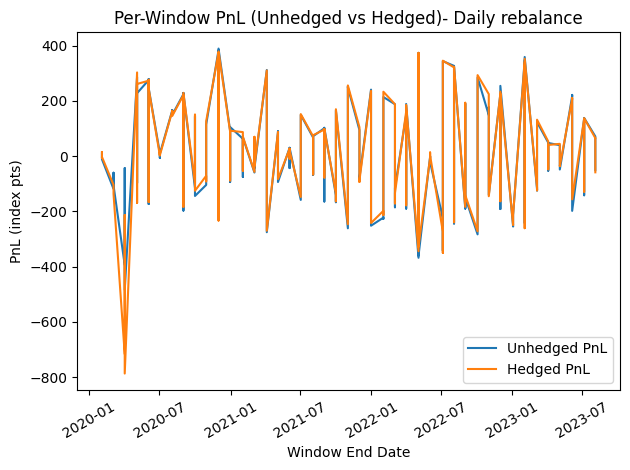

In [18]:

# === E) Plot: per-window PnL ===
res = results_df.sort_values('end').reset_index(drop=True).copy()
plt.figure()
plt.plot(res['end'], res['pnl_unhedged'], label='Unhedged PnL')
plt.plot(res['end'], res['pnl_hedged'], label='Hedged PnL')
plt.title('Per-Window PnL (Unhedged vs Hedged)- Daily rebalance')
plt.xlabel('Window End Date'); plt.ylabel('PnL (index pts)'); plt.legend(); plt.xticks(rotation=30); plt.tight_layout(); plt.show()


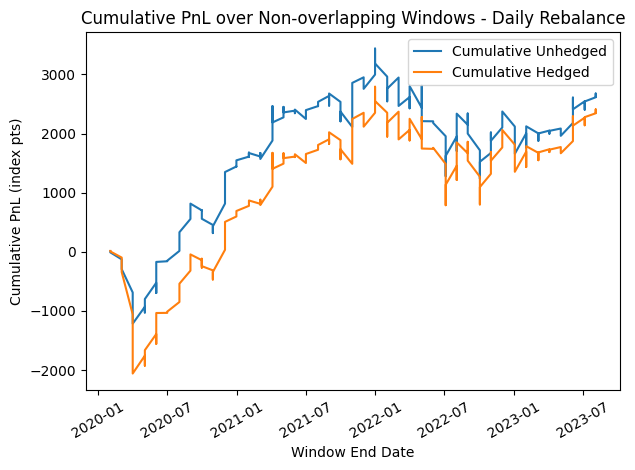

In [19]:

# === F) Plot: cumulative PnL ===
res = results_df.sort_values('end').reset_index(drop=True).copy()
res['cum_unhedged'] = res['pnl_unhedged'].cumsum()
res['cum_hedged']   = res['pnl_hedged'].cumsum()
plt.figure()
plt.plot(res['end'], res['cum_unhedged'], label='Cumulative Unhedged')
plt.plot(res['end'], res['cum_hedged'], label='Cumulative Hedged')
plt.title('Cumulative PnL over Non-overlapping Windows - Daily Rebalance')
plt.xlabel('Window End Date'); plt.ylabel('Cumulative PnL (index pts)'); plt.legend(); plt.xticks(rotation=30); plt.tight_layout(); plt.show()


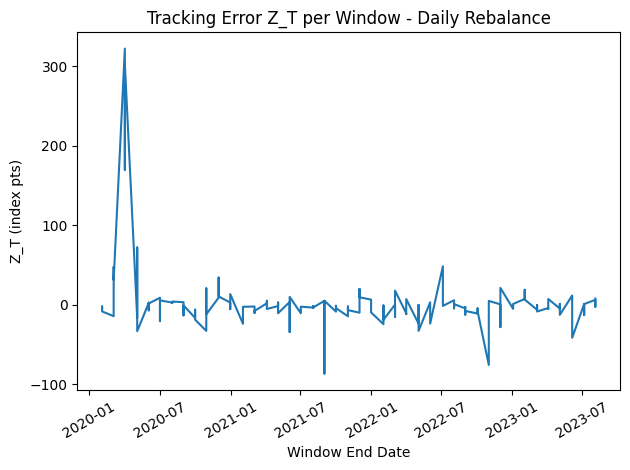

<Figure size 640x480 with 0 Axes>

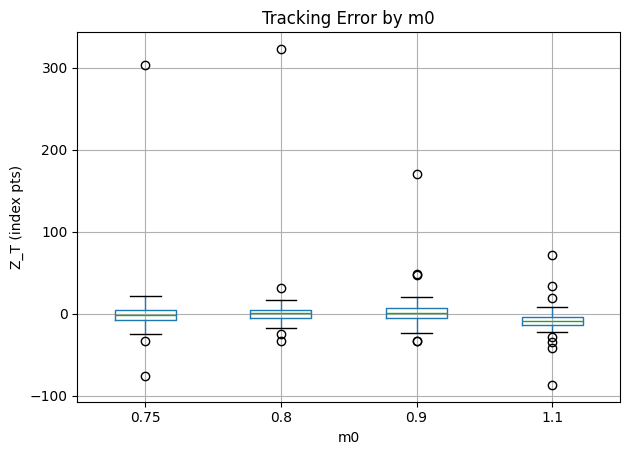

In [20]:

# === G) Plots: tracking error ===
res = results_df.sort_values('end').reset_index(drop=True).copy()
plt.figure()
plt.plot(res['end'], res['tracking_error'])
plt.title('Tracking Error Z_T per Window - Daily Rebalance'); plt.xlabel('Window End Date'); plt.ylabel('Z_T (index pts)')
plt.xticks(rotation=30); plt.tight_layout(); plt.show()

plt.figure()
results_df.boxplot(column='tracking_error', by='m0')
plt.title('Tracking Error by m0'); plt.suptitle(''); plt.xlabel('m0'); plt.ylabel('Z_T (index pts)')
plt.tight_layout(); plt.show()


In [21]:

# === Helper: get day-level timeline for a chosen results row ===
def get_timeline_for_row(df_slice, results, idx=0):
    row = results.iloc[idx]
    dates_arr = np.sort(df_slice['date'].unique())
    si = int(np.where(dates_arr == pd.Timestamp(row['start']))[0][0])
    out = run_single_window(df_slice, start_idx=si, m0=float(row['m0']))
    if out is None:
        raise RuntimeError("Window failed; check console logs for the failing day/leg.")
    return out['timeline'], out['summary']

# Example:
# tl, summ = get_timeline_for_row(df_1m_bt, results_df, idx=0)
# tl.head()


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_2596\2901913625.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{m0}-f{int(f)}" for m0 in perf_summary['m0'] for f in perf_summary[perf_summary['m0']==m0]['rebalance_every']], rotation=45)


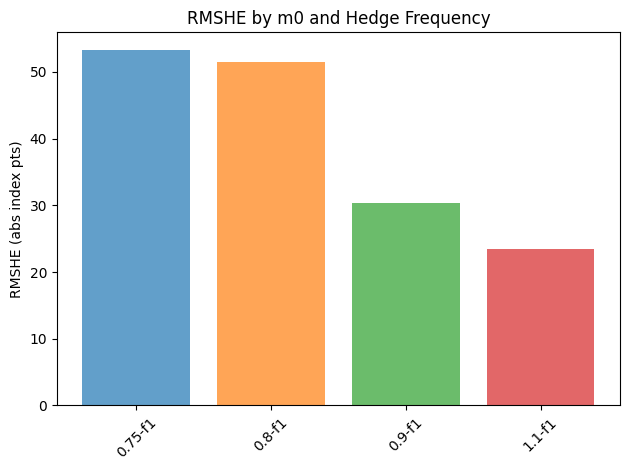

In [22]:
fig, ax = plt.subplots()
for m0 in sorted(results_df['m0'].unique()):
    sub = perf_summary[perf_summary['m0'] == m0]
    ax.bar(
        [f"{m0}-freq{int(f)}" for f in sub['rebalance_every']],
        sub['RMSHE'],
        alpha=0.7,
        label=f"m0={m0}"
    )
ax.set_title("RMSHE by m0 and Hedge Frequency")
ax.set_ylabel("RMSHE (abs index pts)")
ax.set_xticklabels([f"{m0}-f{int(f)}" for m0 in perf_summary['m0'] for f in perf_summary[perf_summary['m0']==m0]['rebalance_every']], rotation=45)
plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

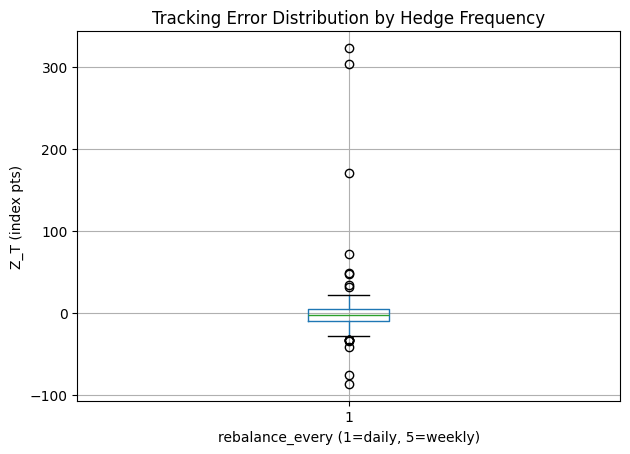

In [23]:
plt.figure()
results_df.boxplot(
    column='tracking_error',
    by='rebalance_every'
)
plt.title("Tracking Error Distribution by Hedge Frequency")
plt.suptitle("")
plt.xlabel("rebalance_every (1=daily, 5=weekly)")
plt.ylabel("Z_T (index pts)")
plt.tight_layout()
plt.show()


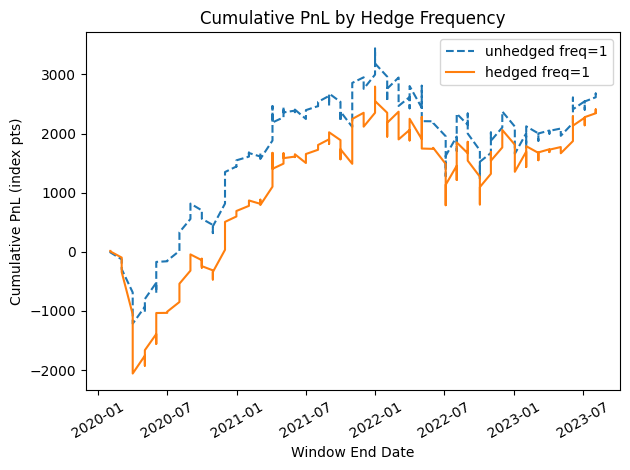

In [24]:
# sort results by end date so time flows on x
res_sorted = results_df.sort_values('end').copy()

plt.figure()
for freq in sorted(res_sorted['rebalance_every'].unique()):
    subf = res_sorted[res_sorted['rebalance_every']==freq].copy()
    subf['cum_hedged']   = subf['pnl_hedged'].cumsum()
    subf['cum_unhedged'] = subf['pnl_unhedged'].cumsum()

    plt.plot(subf['end'], subf['cum_unhedged'], label=f"unhedged freq={freq}", linestyle='--')
    plt.plot(subf['end'], subf['cum_hedged'],   label=f"hedged freq={freq}",   linestyle='-')

plt.title("Cumulative PnL by Hedge Frequency")
plt.xlabel("Window End Date")
plt.ylabel("Cumulative PnL (index pts)")
plt.xticks(rotation=30)
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
results_df.to_csv('results_deltavega.csv', index=False)
print("Delta results saved to results_deltavega.csv")

Delta results saved to results_deltavega.csv
